In [1]:
import torch
import clip
from PIL import Image
import os
# Tải mô hình và bộ mã hóa
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print(device)
# Đoạn mô tả văn bản

cpu


chỗ này để lấy data thôi

In [ ]:
import requests
path = "/Users/vothanhnhan/Desktop/gift/AIC/datasets/food/Images/Train"
# https://www.kaggle.com/datasets/quandang/vietnamese-foods
foods = []
tags = []
for tag in os.listdir(path):
    tags.append(tag)
    food_path = os.path.join(path,tag)
    food = []
    for img in os.listdir(food_path):
        foods.append(os.path.join(food_path,img))
    #foods.append(food)
food_test = []
tags_test = []
for tag in os.listdir("/Users/vothanhnhan/Desktop/gift/AIC/datasets/food/Images/Test"):
    tags_test.append(tag)
    food_path = os.path.join("/Users/vothanhnhan/Desktop/gift/AIC/datasets/food/Images/Test",tag)
    food = []
    for img in os.listdir(food_path):
        food_test.append(os.path.join(food_path,img))
    #foods.append(food)



In [40]:
print(foods[:3])

['/Users/vothanhnhan/Desktop/gift/AIC/datasets/food/Images/Train/Banh gio/189.jpg', '/Users/vothanhnhan/Desktop/gift/AIC/datasets/food/Images/Train/Banh gio/77.jpg', '/Users/vothanhnhan/Desktop/gift/AIC/datasets/food/Images/Train/Banh gio/604.jpg']


cái này là chạy tính trung bình cosine từng món 

In [45]:

def learning_data(food,model): 
    image_features_list = []
    for image_path in food:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            image_features_list.append(image_features)
    return image_features_list


def features_text(text,model):
    text_inputs = torch.cat([clip.tokenize(text)]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
    return text_features

In [46]:
import numpy as np
def process(foods, tags,model):
    probs = 0
    for food,tag in zip(foods,tags):
        food_features = learning_data(food,model)
        text = features_text(tag,model)
        prob = np.array([torch.nn.functional.cosine_similarity(text, feature, dim=1).item() for feature in food_features]).mean()
        print(f"{tag}: {prob}")
        probs += prob 
    print(f"total: {probs/30}")
    

KeyboardInterrupt: 

In [28]:
import clip
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os


cái này là setup cái data nè 

In [56]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, captions_file, preprocess):
        self.data_dir = data_dir
        self.captions = captions_file
        self.preprocess = preprocess

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        image = Image.open(self.data_dir[idx])
        image = self.preprocess(image)
        text = clip.tokenize([caption])[0]
        return image, text


In [79]:

batch_size = 64

# Load CLIP model and preprocess function
model, preprocess = clip.load("ViT-B/32", device="cpu")

# Create dataset and dataloader
dataset = CustomDataset(foods, tags, preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset_test = CustomDataset(food_test, tags_test, preprocess)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [80]:
model = model.to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

mới đổi qua contrastive_loss thay vì cross_entropy thử mà thấy nó cũng vậy à 

In [81]:
import torch.nn.functional as F

def contrastive_loss(logits_per_image, logits_per_text, margin=0.2):
    batch_size = logits_per_image.shape[0]
    labels = torch.arange(batch_size, device=logits_per_image.device)
    
    loss_img = F.cross_entropy(logits_per_image, labels)
    loss_txt = F.cross_entropy(logits_per_text, labels)
    
    pos_sim = torch.sum(F.cosine_similarity(logits_per_image, logits_per_text, dim=-1))
    neg_sim = torch.sum(F.cosine_similarity(logits_per_image, logits_per_text[torch.randperm(batch_size)], dim=-1))
    
    loss = (loss_img + loss_txt) / 2 + margin * (neg_sim - pos_sim)
    
    return loss



In [82]:
num_epochs = 15
loss_process = []
eval_process = []
model.train()
margin = 0.2
for epoch in range(num_epochs):
    for images, texts in dataloader:
        images = images.to("cpu")
        texts = texts.to("cpu")
        
        optimizer.zero_grad()
        
        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)
        loss = contrastive_loss(logits_per_image, logits_per_text, margin)
        loss_process.append(loss.item())
        # Backward pass
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
    model.eval()
    with torch.no_grad():
        cosine_similarities = []
        for images, texts in dataloader_test:
            images = images.to(device)
            texts = texts.to(device)
            
            image_features = model.encode_image(images)
            text_features = model.encode_text(texts)
            
            cosine_similarity = torch.nn.functional.cosine_similarity(image_features, text_features)
            cosine_similarities.append(cosine_similarity.mean().item())
    
    avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
    eval_process.append(avg_cosine_similarity)
    print(f"Average Cosine Similarity after epoch {epoch + 1}: {avg_cosine_similarity}")
    
    model.train()


Epoch 1/15, Loss: 4.797317028045654
Average Cosine Similarity after epoch 1: 0.23309174180030823
Epoch 2/15, Loss: 4.0250678062438965
Average Cosine Similarity after epoch 2: 0.2319287657737732
Epoch 3/15, Loss: 3.4101881980895996
Average Cosine Similarity after epoch 3: 0.23088335990905762
Epoch 4/15, Loss: 2.9130640029907227
Average Cosine Similarity after epoch 4: 0.22978618741035461
Epoch 5/15, Loss: 2.5069618225097656
Average Cosine Similarity after epoch 5: 0.22852210700511932
Epoch 6/15, Loss: 2.1761512756347656
Average Cosine Similarity after epoch 6: 0.22713592648506165


KeyboardInterrupt: 

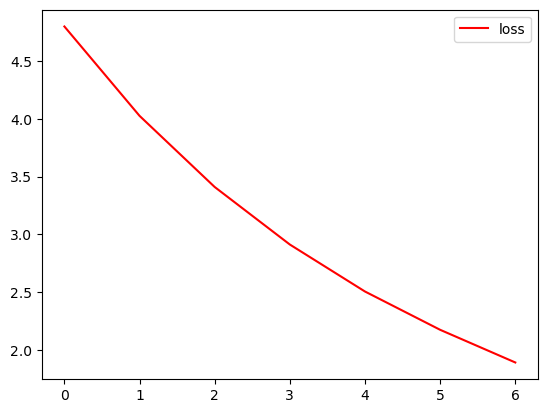

In [83]:
import matplotlib.pyplot as plt
plt.plot(loss_process, 'r-', label = 'loss')
plt.legend()

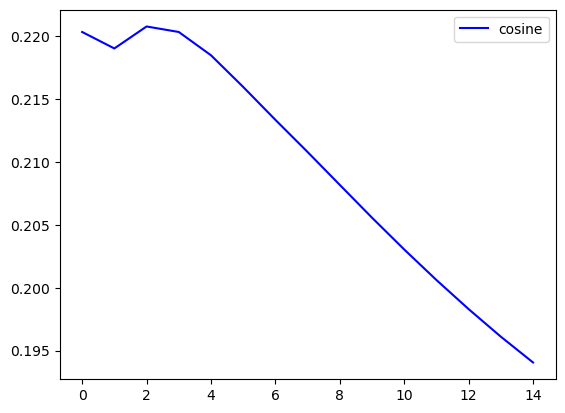

In [72]:
plt.plot(eval_process, 'b-', label = 'cosine')
plt.legend()

In [62]:
#process(foods,tags,model) 

Banh gio: 0.1834156206542892
Canh chua: 0.19136203905532018
Banh cuon: 0.1811039931418603


KeyboardInterrupt: 